# P2: Stereo Matching (revisited)

In [646]:
import cv2
import matplotlib.image as mpimg
X_L=mpimg.imread('data\im0.ppm')
X_R=mpimg.imread('data\im8.ppm')
#X_L = np.asarray(X_L)
#X_R = np.asarray(X_R)
print("Shape of Image: ",X_L.shape)

Shape of Image:  (381, 430, 3)


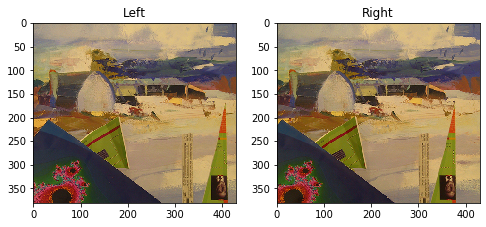

In [647]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 15))

im = axs[0].imshow(X_L)
axs[0].set_title("Left")

im = axs[1].imshow(X_R)
axs[1].set_title("Right")

plt.show()

In [648]:
D = np.zeros((X_R.shape[0],X_R.shape[1]-40))
for i in range(X_L.shape[0]):
    for j in range(X_L.shape[1]-40):
        indexes = np.sqrt(np.sum(np.square(X_R[i,j,:]- X_L[i,j:j+40,:]), axis = 1))
        D[i][j] = indexes.argmin()

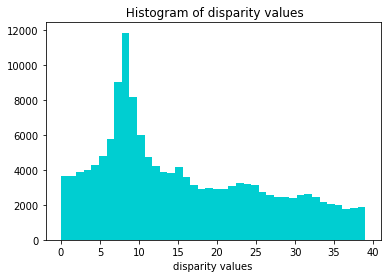

In [649]:
D_Vector = D.flatten()
plt.hist(D_Vector, color = "darkturquoise", bins=40)
plt.title(' Histogram of disparity values')
plt.xlabel('disparity values')
plt.show()

In [650]:
def E_step(n_clusters,data,prob,var,mu):
    N=np.zeros((len(data), n_clusters))
    U=np.zeros((len(data), n_clusters))
    P_N=np.zeros((len(data), n_clusters))
    for j in range(n_clusters):
        N[:,j] = (1/np.sqrt(2*np.pi* var[j]))* np.exp((-1/2)*np.square((data-mu[j]))*(1/var[j]))
        P_N[:,j] =prob[j]*N[:,j]
    #print(var)
    for j in range(n_clusters):
        U[:,j] = np.divide(P_N[:,j],P_N.sum(axis=1))
    
    return U
        

In [651]:
def M_step(n_clusters,U,data):
    mu=np.zeros(n_clusters)
    var=np.zeros(n_clusters)
    prob=np.zeros(n_clusters)
    for j in range(n_clusters):
        mu[j]=(U[:,j].dot(data))/sum(U[:,j])
        #print(mu,sum(U[:,j]))
        var[j] = (U[:,j].dot(np.square(data-mu[j])))/sum(U[:,j])
       # sigma[j] = np.sqrt((U[:,j].dot(np.square(data-mu[j])))/sum(U[:,j]))
        prob[j]=sum(U[:,j])/len(U[:,j])    
    return mu,var,prob
        

In [652]:
def GMM(n_clusters,data,prob,var,mu):
    e=1e-4
    delta =np.ones(n_clusters)*e
    conv = False
    while not conv:
        U=E_step(n_clusters,data,prob,var,mu)
        new_mu,var,prob= M_step(n_clusters,U,data)
        # Checking for convergence
        conv = np.allclose(new_mu,mu, atol = e)
        #print(new_mu,mu)
        mu = new_mu
        #print(mu)
    return mu,var,prob,U

In [709]:
n=4
mu =np.random.choice(D_Vector, size=n, replace=False)
var= np.random.randint(1,40,n)# standard deviation = sigma and variance = sigma^2
prob= np.random.random(n) #np.random.uniform(0,1,size=n) #np.array([1,1,1])/n
prob = prob/sum(prob)

In [710]:
GMM_mu,GMM_var,GMM_prob,U = GMM(n,D_Vector,prob,var,mu)
Cluster_points = [D_Vector[np.rint(U[:,i])>0] for i in range(n)]

In [712]:
import copy
depth_map = copy.deepcopy(D_Vector)
for i in range(n):
    depth_map[np.rint(U[:,i])>0] = GMM_mu[i]
depth_map = depth_map.reshape((D.shape[0],D.shape[1]))

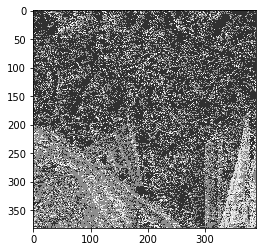

In [713]:
plt.imshow(depth_map,  cmap='gray',vmin=0, vmax=depth_map.max())
plt.show()

In [714]:
# Find the neighbours for (i, j)
def neighbours(grid, i, j):
    pos_neigh=((i-1,j-1),(i-1,j),(i-1,j+1),(i,j+1),(i+1,j+1),(i+1,j),(i+1,j-1),(i,j-1))
    # Return only neighbours that are valid
    return [ pos for pos in pos_neigh if 0 <= pos[0] < grid.shape[0]  and 0 <= pos[1] < grid.shape[1]]
#def P(var,mu,x):
#     return (1/np.sqrt(2*np.pi* var))* np.exp((-1/2)*np.square((x-mu))*(1/var))
def f(mu,k,l,X):
    if mu==X[k,l]:
        return 0
    else:
        return 3
def prior_class(mu,k,l,X,sigma=3):
    return np.exp((-1*f(mu,k,l,X)**2)/sigma)

In [715]:
u=U.reshape((381,390,n))

In [717]:
#ICM
#Initialization
X = copy.deepcopy(depth_map)
smoothen =np.zeros((X.shape))
for iters in range(5):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            latent = -np.inf
            latent_post = -np.inf
            for c in range(n):
                log_likelihood = np.log10(u[i,j,c]+1e-10)
                log_prior=0
                for kl in neighbours(X, i, j):
                    log_prior+=np.log10(prior_class(GMM_mu[c],kl[0],kl[1],X)+1e-10)
                log_post = log_likelihood + log_prior
                if log_post > latent_post:
                    latent = c
                    latent_post=log_post
            smoothen[i][j] =GMM_mu[latent]
    X = copy.deepcopy(smoothen)
    print(iters)


0
1
2
3
4


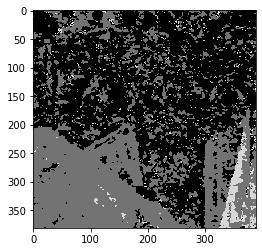

In [718]:
plt.imshow(X,  cmap='gray')
plt.show()